<a href="https://colab.research.google.com/github/chrisrichardson/fenics-tutorial/blob/main/Helmholtz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Helmholtz equation for wave-like problems at steady state

Solve the problem:

$$ \nabla^2 u + k^2 u = 0 $$

on a flat plate, with a circular cut-out.

### N.B. complex numbers, so uses a different FEniCS install!

In [1]:
# Install FEniCSx packages
try:
    import dolfinx
except ImportError:
    !wget -q -nc "https://fem-on-colab.github.io/releases/fenicsx-install-release-complex.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh" >& err.log
    import dolfinx


In [201]:
# Import packages
from mpi4py import MPI
from petsc4py import PETSc

import numpy as np

# Visualisation
import pyvista
pyvista.global_theme.jupyter_backend = 'static'
pyvista.global_theme.notebook = True

# FEniCS DSL
import ufl
from ufl import (Identity, grad, dx, TestFunction, TrialFunction,
                 inner)

from dolfinx.io import XDMFFile
from dolfinx.plot import vtk_mesh
from dolfinx.fem import functionspace, dirichletbc, locate_dofs_topological
from dolfinx.fem import form, Constant, Function
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting


In [202]:
# Download the mesh
!wget -q -nc https://raw.githubusercontent.com/chrisrichardson/fenics-tutorial/refs/heads/main/helmholtz.xdmf
!wget -q -nc https://raw.githubusercontent.com/chrisrichardson/fenics-tutorial/refs/heads/main/helmholtz.h5

In [203]:
# Load mesh into memory
with XDMFFile(MPI.COMM_WORLD, "helmholtz.xdmf", "r") as xdmf:
    mesh = xdmf.read_mesh()
    mesh.topology.create_entities(1)
    facet_tags = xdmf.read_meshtags(mesh, "facet_tags")

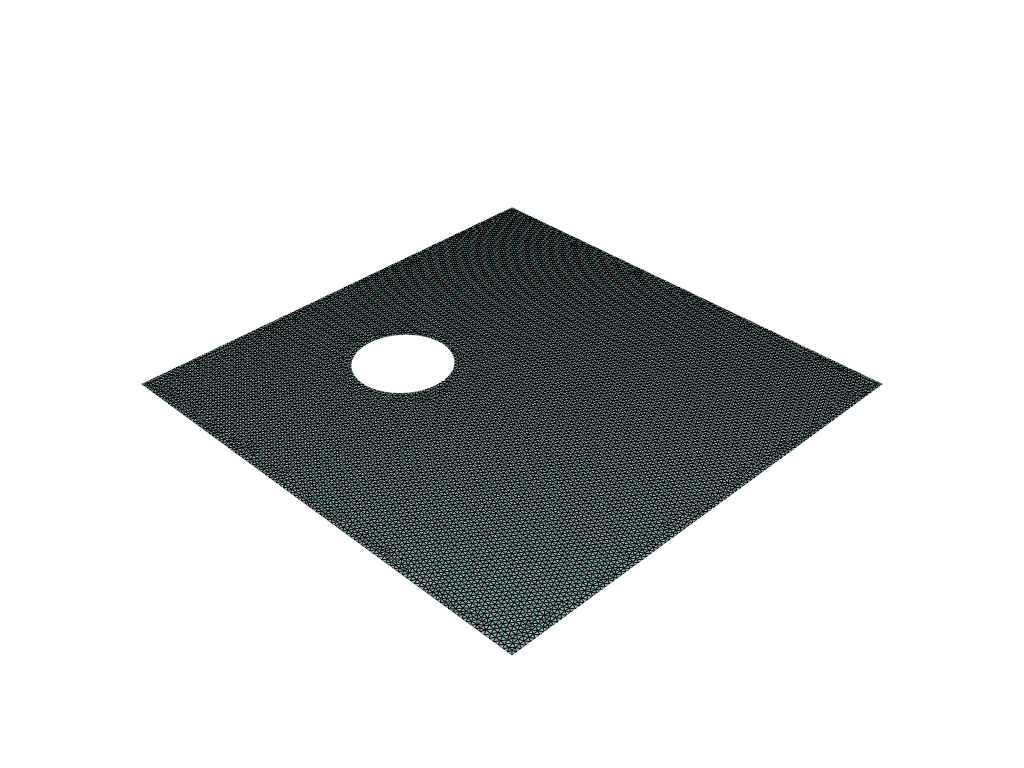

In [204]:
plotter = pyvista.Plotter()
grid = pyvista.UnstructuredGrid(*vtk_mesh(mesh));
plotter.add_mesh(grid, show_edges=True)
plotter.show()

Define the Finite Element problem

In [229]:
# Linear functionspace of scalars
V = functionspace(mesh, ("Lagrange", 1))
u, v = TrialFunction(V), TestFunction(V)

k = Constant(mesh, 30.0 + 1.0j)
source = Constant(mesh, 0.0 + 0.0j)

a = form((inner(grad(u), grad(v)) - k**2 * inner(u, v)) * dx)
L = form(inner(source, v) * dx)

Set values for the BCs

In [230]:
# Get lists of facets from mesh data to apply BCs
mesh.topology.create_connectivity(1, 2) # topological connectivity f->c
facets = [facet_tags.find(j) for j in range(10)]
for i, f in enumerate(facets):
  print(f"Label {i} has {len(f)} facets")

# BC0 on the external boundary (6, 7, 8, 9)
T_base = Constant(mesh, 0.0 + 0.0j)
bc0 = dirichletbc(T_base, locate_dofs_topological(V, entity_dim=1,
                                                  entities=np.concatenate((facets[6],
                                                                         facets[7],
                                                                         facets[8],
                                                                         facets[9]))), V=V)

# BC1 on the circular boundary (5)
T_src = Constant(mesh, 1.0 + 0.0j)
bc1 = dirichletbc(T_src,
                  locate_dofs_topological(V,
                                          entity_dim=1,
                                          entities=facets[5]),
                                          V=V)


Label 0 has 0 facets
Label 1 has 0 facets
Label 2 has 0 facets
Label 3 has 0 facets
Label 4 has 0 facets
Label 5 has 63 facets
Label 6 has 100 facets
Label 7 has 100 facets
Label 8 has 100 facets
Label 9 has 100 facets


Assemble and solve problem

In [231]:

A = assemble_matrix(a, bcs=[bc0, bc1])
A.assemble()

# Setup the solver
ksp = PETSc.KSP().create(mesh.comm)
ksp.setOperators(A)
ksp.setType("preonly")
ksp.getPC().setType("lu")

b = assemble_vector(L)
apply_lifting(b, [a], bcs=[[bc0, bc1]])
bc0.set(b.array)
bc1.set(b.array)

u0 = Function(V)
ksp.solve(b, u0.x.petsc_vec)


Visualise real part of solution

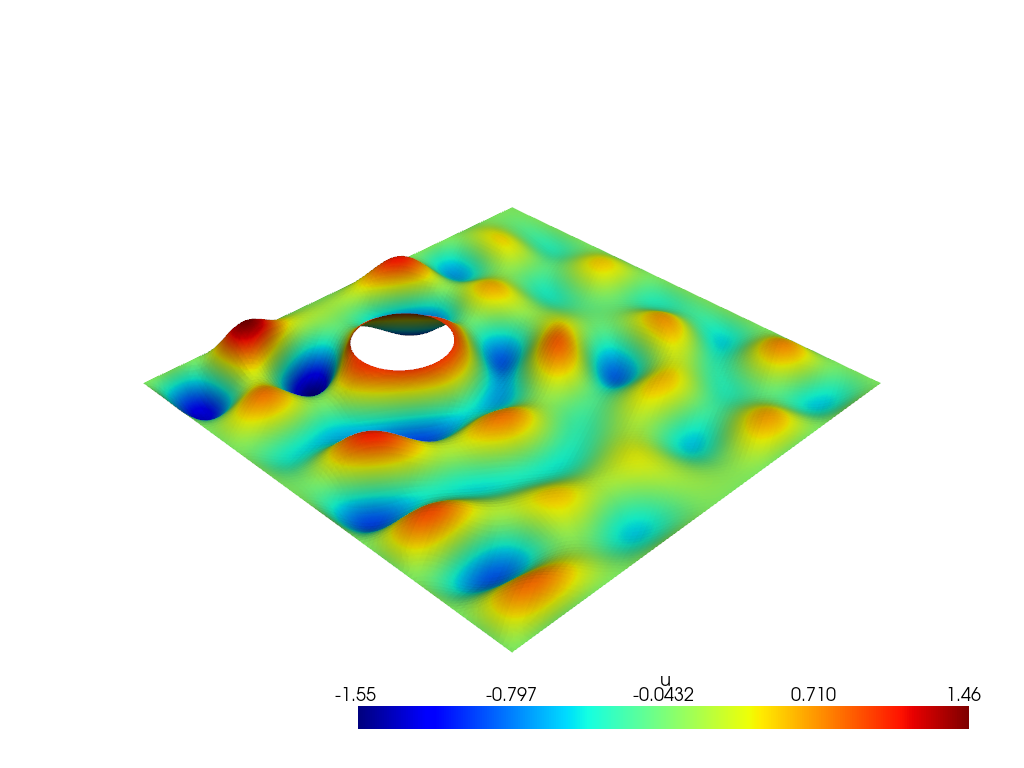

In [232]:
plotter = pyvista.Plotter()
grid = pyvista.UnstructuredGrid(*vtk_mesh(mesh));
grid.point_data["u"] = np.real(u0.x.array[:])
grid.set_active_scalars("u")
grid.warp_by_scalar("u", factor=.05, inplace=True)
plotter.add_mesh(grid, show_edges=False, cmap='jet')
plotter.show()

In [ ]:
# Experiment with the constant values and BCs.
# Plot the imaginary part too.
# Extension: make an animation (can be done by multiplying the solution by a complex unit vector which changes direction)
